In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

Using TensorFlow backend.


In [2]:
DS = pd.read_csv("ObjectSubset150SentenceLength.csv")

In [3]:
DS['tag'].fillna('O', inplace=True)

In [4]:
words = list(set(DS["word"].values))
n_words = len(words)
n_words

27741

In [5]:
tags = list(set(DS["tag"].values))
n_tags = len(tags); n_tags


2

In [6]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(DS)

In [8]:
sentences = getter.sentences


In [9]:
sentences[1]

[('Pt.', 'O'),
 ('tehtud', 'O'),
 ('3', 'O'),
 ('plasmaferees,', 'O'),
 ('talus', 'O'),
 ('hästi.', 'O'),
 ('Eemaldatud', 'O'),
 ('700', 'O'),
 ('ml', 'O'),
 ('plasmat.', 'O'),
 ('RR', 'object'),
 ('112/60', 'object'),
 ('mmHg.', 'O'),
 ('Tgasi', 'O'),
 ('22.10.09.', 'O')]

In [10]:
# np.median([len(s) for s in sentences])
DS.word.apply(lambda x: len(x)).describe()

count    157280.000000
mean          6.230697
std           4.330117
min           1.000000
25%           3.000000
50%           5.000000
75%           9.000000
max          54.000000
Name: word, dtype: float64

In [11]:
LengthsList = []
for i in range(len(sentences)):
    LengthsList.append(len(sentences[i]))
np.max(LengthsList)

150

In [12]:
sentences[6]

[('Kokkuvõte:', 'O'),
 ('<ANONYM', 'O'),
 ('id="0"', 'O'),
 ('type="per"', 'O'),
 ('morph="_A_', 'O'),
 ('sg', 'O'),
 ('n"/>', 'O'),
 ('nähtava', 'O'),
 ('patoloogiata.', 'O'),
 ('Kokkuvõte:', 'O'),
 ('<ANONYM', 'O'),
 ('id="0"', 'O'),
 ('type="per"', 'O'),
 ('morph="_A_', 'O'),
 ('sg', 'O'),
 ('n"/>', 'O'),
 ('nähtava', 'O'),
 ('patoloogiata.', 'O'),
 ('Kokkuvõte:', 'O'),
 ('<ANONYM', 'O'),
 ('id="0"', 'O'),
 ('type="per"', 'O'),
 ('morph="_A_', 'O'),
 ('sg', 'O'),
 ('n"/>', 'O'),
 ('nähtava', 'O'),
 ('patoloogiata.', 'O'),
 ('Kokkuvõte:', 'O'),
 ('<ANONYM', 'O'),
 ('id="0"', 'O'),
 ('type="per"', 'O'),
 ('morph="_A_', 'O'),
 ('sg', 'O'),
 ('n"/>', 'O'),
 ('nähtava', 'O'),
 ('patoloogiata.', 'O'),
 ('Kokkuvõte:', 'O'),
 ('<ANONYM', 'O'),
 ('id="0"', 'O'),
 ('type="per"', 'O'),
 ('morph="_A_', 'O'),
 ('sg', 'O'),
 ('n"/>', 'O'),
 ('nähtava', 'O'),
 ('patoloogiata.', 'O'),
 ('Kokkuvõte:', 'O'),
 ('<ANONYM', 'O'),
 ('id="0"', 'O'),
 ('type="per"', 'O'),
 ('morph="_A_', 'O'),
 ('sg', 'O')

In [13]:
max_len = 150
max_len_char = 10

In [14]:
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [15]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


104


In [16]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1 #For predictions
char2idx["PAD"] = 0

In [17]:
idx2char = {i: w for w, i in char2idx.items()}

In [18]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [19]:
y = [[tag2idx[w[1]] for w  in s] for s in sentences]


In [20]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [21]:
tag2idx

{'object': 1, 'O': 2, 'PAD': 0}

In [22]:
from sklearn.model_selection import train_test_split
X_char_tr, X_char_te, y_tr,  y_te= train_test_split(X_char, y, test_size=0.2, random_state=2018)


In [23]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = SpatialDropout1D(0.3)(char_enc)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model( char_in, out)
 




In [24]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 10)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 10, 10)       1060      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 150, 20)           2480      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 20)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 100)          28400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 150, 3)            303       
Total params: 32,243
Trainable params: 32,243
Non-trainable params: 0
_______________________________________________________

In [25]:
history = model.fit(np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char)),
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 75s 8ms/step - loss: 0.0221 - acc: 0.9234 - val_loss: 0.0068 - val_acc: 0.9816
Epoch 2/10
9822/9822 [==============================] - 73s 7ms/step - loss: 0.0055 - acc: 0.9828 - val_loss: 0.0043 - val_acc: 0.9855
Epoch 3/10
9822/9822 [==============================] - 73s 7ms/step - loss: 0.0042 - acc: 0.9852 - val_loss: 0.0031 - val_acc: 0.9865
Epoch 4/10
9822/9822 [==============================] - 99s 10ms/step - loss: 0.0033 - acc: 0.9882 - val_loss: 0.0022 - val_acc: 0.9912
Epoch 5/10
9822/9822 [==============================] - 102s 10ms/step - loss: 0.0028 - acc: 0.9900 - val_loss: 0.0018 - val_acc: 0.9927
Epoch 6/10
9822/9822 [==============================] - 103s 10ms/step - loss: 0.0026 - acc: 0.9913 - val_loss: 0.0017 - val_acc: 0.9930
Epoch 7/10
9822/9822 [==============================] - 112s 11ms/step - loss: 0.0024 - acc: 0.9916 - val_loss: 0.0015 - val_acc: 0.9932


In [26]:
hist = pd.DataFrame(history.history)


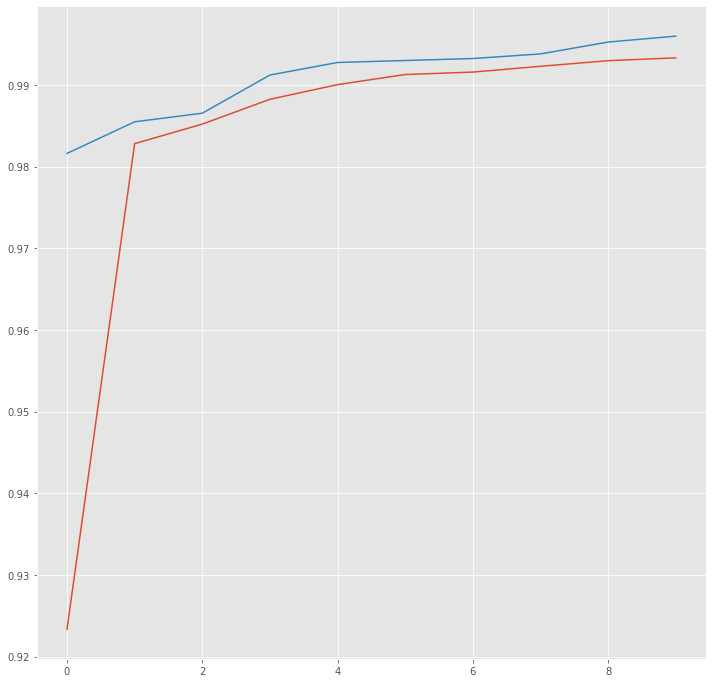

In [27]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [28]:
y_pred = model.predict(
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char)))


In [29]:
def charindx2word(Tword):
    word = []
    for i in range(len(Tword)):
        if(Tword[i] !=0):
            word.append(idx2char[Tword[i]])
    return "".join(word)

In [30]:
idx2char[0]

'PAD'

In [31]:
i = 1000
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if t != 0: #PAD
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
Üldseisnud     : O     O
rahuldav.S     : O     O
regulaarne     : object O
mm             : O     O
Hg.Vesikul     : O     O
hingamiska     : O     O
pehme,valu     : O     O


In [32]:
len(y_pred)

2729

In [40]:
j = 0
for i in range(len(y_pred)):
    p = np.argmax(y_pred[i], axis=-1)
#     print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
#     print(30 * "=")
    for w, t, pred in zip(X_char_te[i], y_te[i], p):
        if charindx2word(w) != "":
            if idx2tag[t] != idx2tag[pred]:
                print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))
                j = j+1


/106           : O     object
90             : O     object
ebaregulaa     : object O
KORRAS.        : object O
KOORMUSTES     : object O
155/95         : object O
24-tunni       : object O
Nõustamine     : object O
=              : O     object
kõikumised     : object O
140-90mmhg     : object O
100            : O     object
sööki-6,6m     : object O
regulaarne     : object O
kaebusteta     : object O
P185           : O     object
regulaarne     : object O
tarvitanud     : object O
135/82         : object O
135/92//85     : O     object
min.Pikkus     : object O
189            : object O
min.Pikkus     : object O
189            : object O
Kordusrets     : object O
46cm,          : object O
Analüüsid.     : object O
184/88         : object O
Analüüsid.     : object O
184/88         : object O
regulaarse     : object O
kukkumisoh     : O     object
170            : object O
sööki-4,3m     : object O
P102           : O     object
PR             : O     object
138            : O     objec

In [41]:
j

183

In [35]:
i = 12
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_char_te[i], y_te[i], p):
    if charindx2word(w) != "":
        print("{:15}: {:5} {}".format(charindx2word(w), idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
RR             : object object
168            : object object
/106           : O     object
Cor            : O     O
toonid         : O     O
regulaarse     : O     O
EHHO           : O     O
:              : O     O
Korrigeeri     : O     O
ravi           : O     O
28.12.2012     : O     O
pearinglus     : O     O
püsib          : O     O
.              : O     O
EHHO-s         : O     O
vahesein       : O     O
1.1-1.2        : O     O
RR170/         : object object
90             : O     O
RR             : object object
168            : object object
/106           : O     O
Cor            : O     O
toonid         : O     O
regulaarse     : O     O
EHHO           : O     O
:              : O     O
Korrigeeri     : O     O
ravi           : O     O
28.12.2012     : O     O
pearinglus     : O     O
püsib          : O     O
.              : O     O
EHHO-s         : O     O
vahesein       : O     O
1.1-1.2        : O     O
RR170/         : object object
90   

In [36]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(y_pred)
test_labels = test2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))


F1-score: 84.1%
           precision    recall  f1-score   support

   object       0.86      0.83      0.84      2104

micro avg       0.86      0.83      0.84      2104
macro avg       0.86      0.83      0.84      2104



In [38]:
from sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

           O       1.00      0.92      0.96    405697
      object       0.09      0.96      0.17      3653

    accuracy                           0.92    409350
   macro avg       0.55      0.94      0.56    409350
weighted avg       0.99      0.92      0.95    409350

